## CLEAR Line Tracking

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import RF_Track as RF_Track
from scipy.optimize import minimize
import re

## Beam and Lattice parameters

In [6]:
# Beam parameters
mass = RF_Track.electronmass    # particle mass in MeV/c^2
population = 300 * RF_Track.pC               # number of particles per bunch
Q = -1                          # particle charge in e units
P_ref = 198                     # reference momentum in MeV/c

freq = 2.997e9                  # Hz


### Another way 

# energy_MeV = 200
# P_ref = np.sqrt((energy_MeV + 0.511)**2 - 0.511**2)
# print(f"Calculated momentum: {P_calc:.2f} MeV/c")
# population = 50 * RF_Track.pC # number of real particles per bunch

In [7]:
### Lattice parameters
nr_quad = 11
Lquad = 0.226  # magnetic length of the quadrupole in m
nominal_K = 0.7752883624676146 #3.35  # 1/m

# Integral Transfer Function
def get_ITF(I):
    return 1.29404711e-2  - 2.59458259e-07*I # T/A

def get_grad(I, Lquad):
    G_0 = I * get_ITF(I) / Lquad    # T/m
    return G_0

def get_Quad_K(G_0, P_ref):
    K = 299.8 *G_0 / P_ref  # 1/m^2
    return K

def get_Quad_K_from_I(I, Lquad, P_ref):
    G_0 = get_grad(I, Lquad)
    K = get_Quad_K(G_0, P_ref)
    return K

In [8]:
## ENTIRE CLEAR LINE LATTICE CONSTRUCTION, FROM THE SURVEY FILE

# Source (November 2024)
# https://gitlab.cern.ch/acc-models/acc-models-clear/-/blob/master/survey/clear.survey0_filtered.tfs?ref_type=heads

# Load survey file
with open("../Interfaces/CLEAR/CLEAR_Beamline_Survey.txt", encoding="utf-8", errors="ignore") as f:
    lines = f.readlines()

# Loop through the survey line-by-line and construct a dict of all relevant elements
element_descriptions = {}
previous_name = None
quad_index = 0
corr_index = 0
for line in lines:
    # Skip preamble
    if line[0:2] != ' "':
        continue

    # Find relevant parts of text
    text = re.findall(r'"([A-Za-z0-9.$_]+)"', line)
    numbers = re.findall(r'\d+\.\d+', line)

    name = text[0]

    # Skip unused screens
    if name == 'CA.BTV0800':
        continue

    # Specify element type
    element_type = None
    if 'QFD' in name or 'QDD' in name:
        element_type = 'Quadrupole'
    elif 'BTV' in name:
        element_type = 'Screen'
    elif 'DHG' in name or 'DHJ' in name:
        element_type = 'Corrector'
    elif 'BPC' in name or 'BPM' in name:
        element_type = 'BPM'
    elif text[1] == 'MARKER':
        element_type = 'Marker'

    # If the element type is none of the above, skip this element
    if element_type is None:
        continue

    # Set length and position
    s_end = float(numbers[0])
    L = float(numbers[1])
    s_start = s_end - L

    # Round values to remove float errors
    L = round(L, 4)
    s_start = round(s_start, 4)
    s_end = round(s_end, 4)

    # Add drift from previous element
    if previous_name is not None:
        L_drift = round(s_start - element_descriptions[previous_name]['s_end'], 4)
        if L_drift != 0:
            element_descriptions[previous_name + ' Drift'] = {
                'element_type': 'Drift',
                'L': L_drift,
                's_start': element_descriptions[previous_name]['s_end'], 
                's_end': s_start,
                'quad_index': None,
                'corr_index': None,
            }

    # Add current element
    element_descriptions[name] = {
        'element_type': element_type,
        'L': L,
        's_start': s_start, 
        's_end': s_end,
        'quad_index': quad_index if element_type == 'Quadrupole' else None,
        'corr_index': corr_index if element_type == 'Corrector' else None,
    }

    if element_type == 'Quadrupole':
        quad_index += 1

    if element_type == 'Corrector':
        corr_index += 1
    
    previous_name = name

# Return a lattice object from start to end, using a current vector with the currents of each quad in order
def get_lattice(start, end, P_ref, quad_currents, include_end = True):
    start_index = list(element_descriptions.keys()).index(start)
    end_index = list(element_descriptions.keys()).index(end)
    if include_end: end_index += 1

    
    lattice = RF_Track.Lattice()
    names = list(element_descriptions.keys())
    elements = list(element_descriptions.values())
    for name, element_description in zip(names[start_index:end_index], elements[start_index:end_index]):
        element_type = element_description['element_type']
        L = element_description['L']
        s_start = element_description['s_start']
        s_end = element_description['s_end']
        quad_index = element_description['quad_index']

        if element_type == 'Drift':
            element = RF_Track.Drift(L)
        elif element_type == 'Quadrupole':
            if 'QFD' in name:
                K = get_Quad_K_from_I(quad_currents[quad_index], L, P_ref)
            elif 'QDD' in name:
                K = -get_Quad_K_from_I(quad_currents[quad_index], L, P_ref)
            element = RF_Track.Quadrupole(L, P_ref/Q, K)
        elif element_type == 'Corrector':
            element = RF_Track.Corrector(L)
        elif element_type == 'BPM':
            element = RF_Track.Bpm(L)
        elif element_type == 'Screen':
            element = RF_Track.Screen()
        elif element_type == 'Marker':
            element = RF_Track.Screen()

        lattice.append(element)

        
    return lattice

start = 'CA.ACS0270S_MECH' # 'CA.QFD0350'
end = 'CA.STLINE$END'
lattice = get_lattice(start, end, P_ref, np.array(11*[0]))


print(lattice.get_length())
print(element_descriptions[end]['s_end'] - element_descriptions[start]['s_start'])

19.318000000000005
19.317999999999998


## ATTENTION: LATTICE CONSTRUCTION AHEAD
## (Build your own lattice)

In [9]:
### ATTENTION ###
# LATTICE CONSTRUCTION AHEAD
quad_currents = np.array([
    0,        #QFD350
    0,        #QDD355
    0,        #QFD360

    0,        #QFD510
    0,        #QDD515
    0,        #QFD520

    0,        #QFD760
    0,        #QDD765
    0,        #QFD770

    0,        #QDD870
    0         #QFD880
])    # A

# Here the lattice is constructed from the desired start to the desired end
L = get_lattice('CA.QFD0350', 'CA.BTV0910', P_ref, quad_currents, include_end=False)

length = L.get_length()
print(length)
print(element_descriptions['CA.BTV0910']['s_end'] - element_descriptions['CA.QFD0350']['s_start'])

17.211
17.211


In [10]:
# Extra drift for In-Air Test Stand

Drift1 = RF_Track.Drift(1.0)
L.append(Drift1)

L.get_length()

18.211

## TWISS PARAMETERS: Insertion, tracking and check

In [11]:
# Twiss parameters
# They have to be inserted here
# They are the ones at the starting point of your constructed lattice

Twiss = RF_Track.Bunch6d_twiss()

Twiss.beta_x = 15.6        # m
Twiss.beta_y = 24 # 2.73        # m
Twiss.alpha_x = -0.49
Twiss.alpha_y = -3.65 # 0.339
Twiss.emitt_x = 7.04     # mm.mrad normalised emittance
Twiss.emitt_y = 3.39 # 0.727      # mm.mrad
# Twiss.sigma_t = 10 * RF_Track.ps       # mm/c   or 37 * RF_Track.ps
# Twiss.sigma_pt = 10     # permille
Twiss.mean_xp = 0.0
Twiss.mean_yp = 0.0

In [12]:
# Setup
N = 10000
P0 = RF_Track.Bunch6d(mass, population, Q, np.array([0,0,0,0,0,P_ref]).T)   # reference particle
B0 = RF_Track.Bunch6d(mass, population, Q, P_ref, Twiss, N)             # reference bunch

# n_bunches = 1
# bunch_spacing = 0.0 * RF_Track.ns # mm/c

# B0 = RF_Track.Beam(n_bunches, Bunch, bunch_spacing)

(10000, 6)


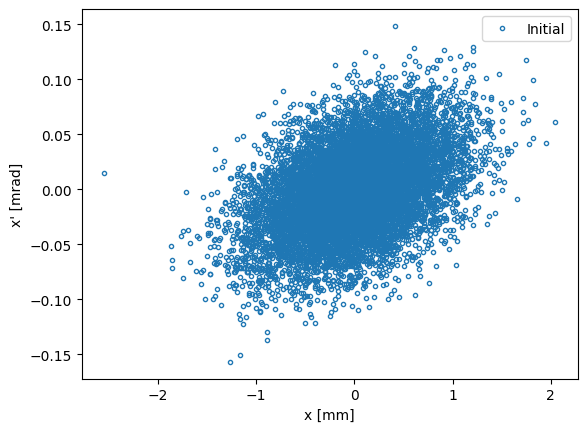

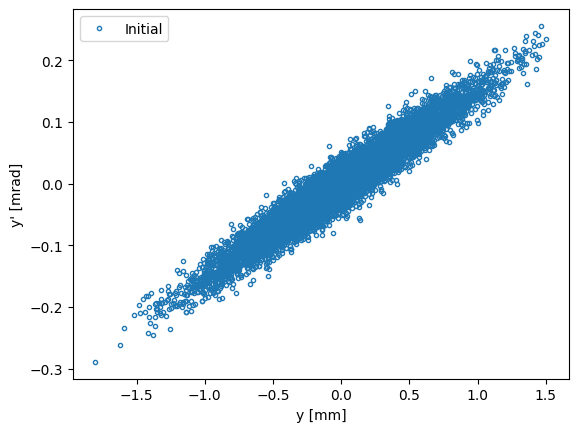

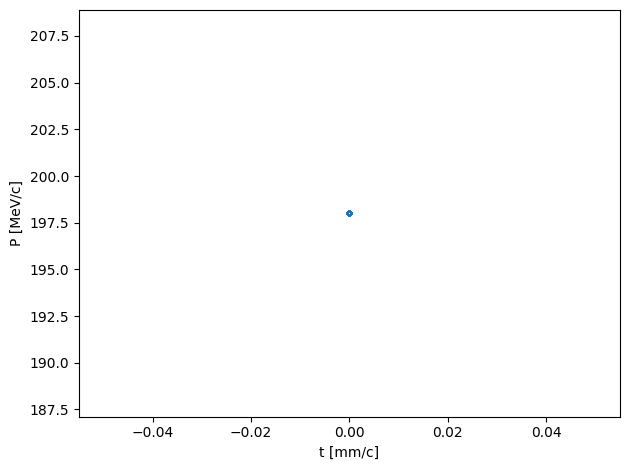

In [13]:
# Initial phase space distribution

M0 = B0.get_phase_space ('%x %xp %y %yp %dt %P')
print(M0.shape)
plt.figure()
plt.plot(M0[:,0], M0[:,1], '.', label='Initial', mfc='none')
plt.xlabel('x [mm]')
plt.ylabel("x' [mrad]")
plt.legend()

plt.figure()
plt.plot(M0[:,2], M0[:,3], '.', label='Initial', mfc='none')
plt.xlabel('y [mm]')
plt.ylabel("y' [mrad]")
plt.legend()

plt.figure()
plt.plot(M0[:,4], M0[:,5], '.', label='Initial', mfc='none')
plt.xlabel('t [mm/c]')
plt.ylabel('P [MeV/c]')
plt.tight_layout()

In [14]:
def get_Twiss(Bunch):
    I0 = Bunch.get_info()
    pos0 = I0.S
    beta_x = I0.beta_x
    beta_y = I0.beta_y
    alpha_x = I0.alpha_x
    alpha_y = I0.alpha_y
    emitt_x = I0.emitt_x
    emitt_y = I0.emitt_y
    sigma_t = I0.sigma_t
    sigma_pt = I0.sigma_pt
    sigma_x = I0.sigma_x
    sigma_y = I0.sigma_y
    mean_x = I0.mean_x
    mean_y = I0.mean_y
    mean_xp = I0.mean_xp
    mean_yp = I0.mean_yp
    return pos0, beta_x, beta_y, alpha_x, alpha_y, emitt_x, emitt_y, sigma_t, sigma_pt, sigma_x, sigma_y, mean_x, mean_y, mean_xp, mean_yp

def print_Twiss(Bunch):
    pos0, beta_x, beta_y, alpha_x, alpha_y, emitt_x, emitt_y, sigma_t, sigma_pt, sigma_x, sigma_y, mean_x, mean_y, mean_xp, mean_yp = get_Twiss(Bunch)
    print(f"Position: {pos0:.2f} m")
    print(f"beta_x: {beta_x:.2f} m")
    print(f"beta_y: {beta_y:.2f} m")
    print(f"alpha_x: {alpha_x:.2f}")
    print(f"alpha_y: {alpha_y:.2f}")
    print(f"emittance_x: {emitt_x:.2f} mm.mrad")
    print(f"emittance_y: {emitt_y:.2f} mm.mrad")
    print(f"sigma_t: {sigma_t:.2f} mm/c")
    print(f"sigma_pt: {sigma_pt:.2f} permille")
    print(f"sigma_x: {sigma_x:.2f} mm")
    print(f"sigma_y: {sigma_y:.2f} mm")
    print(f"mean_x: {mean_x:.2f} mm")
    print(f"mean_y: {mean_y:.2f} mm")
    print(f"mean_xp: {mean_xp:.2f} mrad")
    print(f"mean_yp: {mean_yp:.2f} mrad")


In [15]:
### Initial Twiss params

get_Twiss(B0)
print_Twiss(B0)

Position: 0.00 m
beta_x: 15.36 m
beta_y: 23.95 m
alpha_x: -0.48
alpha_y: -3.64
emittance_x: 7.04 mm.mrad
emittance_y: 3.39 mm.mrad
sigma_t: 0.00 mm/c
sigma_pt: 0.00 permille
sigma_x: 0.53 mm
sigma_y: 0.46 mm
mean_x: -0.00 mm
mean_y: -0.00 mm
mean_xp: -0.00 mrad
mean_yp: 0.00 mrad


In [16]:
# Tracking

P1 = L.track(P0)        # Track the reference particle
B1 = L.track(B0)        # Track the reference bunch

In [17]:
### Final Twiss params
get_Twiss(B1)
print_Twiss(B1)

Position: 18.21 m
beta_x: 59.41 m
beta_y: 353.74 m
alpha_x: -1.94
alpha_y: -14.47
emittance_x: 7.04 mm.mrad
emittance_y: 3.39 mm.mrad
sigma_t: 0.00 mm/c
sigma_pt: 0.00 permille
sigma_x: 1.04 mm
sigma_y: 1.76 mm
mean_x: -0.00 mm
mean_y: -0.00 mm
mean_xp: -0.00 mrad
mean_yp: 0.00 mrad


## Transport Table getting, followed by phase space extraction

In [18]:
T = L.get_transport_table('%S %sigma_x %sigma_y %sigma_t %sigma_E %mean_E %emitt_x %emitt_y %beta_x %beta_y')
M1 = B1.get_phase_space('%x %xp %y %yp %dt %P')
print(M1)
# print(T)

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  1.98000000e+02]
 [ 5.03626329e-02 -1.25200279e-03  4.28322699e-01  8.78380382e-03
   7.16805516e-07  1.98000000e+02]
 [ 1.86045349e+00  5.28550613e-02  3.32077816e-01  7.18604020e-03
   2.59078697e-05  1.98000000e+02]
 ...
 [ 8.11606005e-01  4.81859937e-02  1.92722269e+00  7.06804568e-02
   6.66306041e-05  1.98000000e+02]
 [-6.63992884e-02  2.56418267e-02  2.37240622e-01  4.24796536e-03
   6.15112003e-06  1.98000000e+02]
 [-2.35171385e+00 -6.50298412e-02 -4.18656673e+00 -1.67044963e-01
   2.92586963e-04  1.98000000e+02]]


In [19]:
M0 = B0.get_phase_space('%x %xp %y %yp %dt %P')
print(M0)

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  1.98000000e+02]
 [ 7.31628557e-02 -1.25200279e-03  2.68360848e-01  8.78380382e-03
   0.00000000e+00  1.98000000e+02]
 [ 8.97909967e-01  5.28550613e-02  2.01212838e-01  7.18604020e-03
  -0.00000000e+00  1.98000000e+02]
 ...
 [-6.59091262e-02  4.81859937e-02  6.40060897e-01  7.06804568e-02
  -0.00000000e+00  1.98000000e+02]
 [-5.33362594e-01  2.56418267e-02  1.59880925e-01  4.24796536e-03
   0.00000000e+00  1.98000000e+02]
 [-1.16745542e+00 -6.50298412e-02 -1.14451090e+00 -1.67044963e-01
   0.00000000e+00  1.98000000e+02]]


Text(0, 0.5, 'K [MeV]')

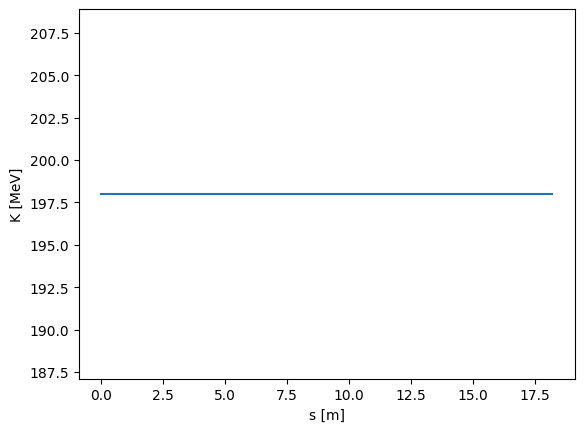

In [20]:
# Momentum over distance

T = L.get_transport_table('%S %mean_P')

plt.plot (T[:, 0], T[:, 1])
plt.xlabel ('s [m]')
plt.ylabel ('K [MeV]')

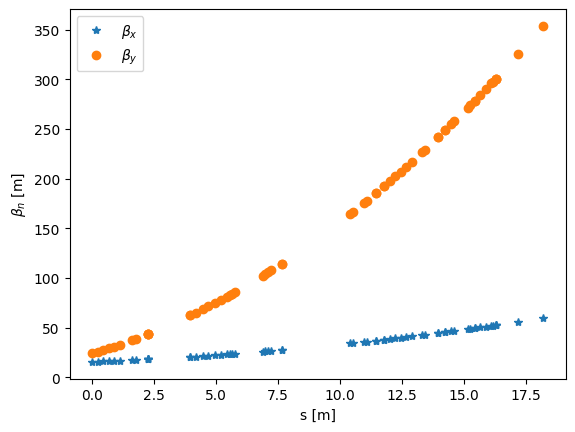

In [21]:
# Beta evolution over the line

T = L.get_transport_table('%S %beta_x %beta_y')  
plt.plot(T[:,0], T[:,1], '*', linewidth=2,)
plt.plot(T[:,0], T[:,2], 'o', linewidth=2,)
plt.legend([r'$\beta_x$', r'$\beta_y$'])
plt.xlabel('s [m]')
plt.ylabel(r'$\beta_n$ [m]')
plt.show()

Screens in lattice:
CA.BTV0390 -> BTV0390 at 20.5564
CA.BTV0620 -> BTV0620 at 25.9344
CA.BTV0730 -> BTV0730 at 29.7544
CA.BTV0810 -> BTV0810 at 32.5494
CA.BTV0910 -> BTV0910 at 35.4944


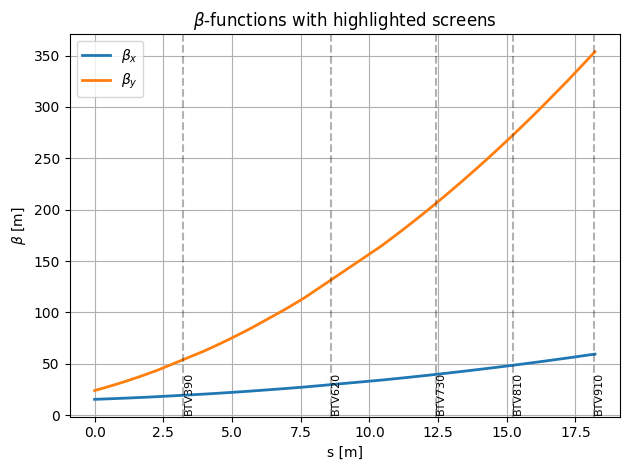

In [22]:
# TO BE USED WITH FULL LATTICE

# Plotting beta functions
plt.plot(T[:, 0], T[:, 1], label=r'$\beta_x$', linewidth=2)
plt.plot(T[:, 0], T[:, 2], label=r'$\beta_y$', linewidth=2)

# Optional: set specific screens to highlight (or set to [] to include all)
highlight_filter = ['BTV390', 'BTV620', 'BTV730', 'BTV810', 'BTV910']  # <- short names
highlight_positions = []
highlight_names = []

# Reconstruct lattice positions
s = 0.0
names = list(element_descriptions.keys())
start_index = names.index(start)
end_index = names.index(end) + 1
names_in_lattice = names[start_index:end_index]

for name in names_in_lattice:
    elem = element_descriptions[name]
    L = elem['L']
    elem_type = elem['element_type']

    if elem_type == 'Screen':
        short_name = name.split('.')[-1].replace('BTV0', 'BTV').replace('BTV', 'BTV')  # unify format
        if not highlight_filter or short_name in highlight_filter:
            # Compute center of element (if L > 0), or use current s (if L == 0)
            center = s + L / 2 if L > 0 else s
            highlight_positions.append(center)
            highlight_names.append(short_name)

    s += L


print("Screens in lattice:")
for name in names_in_lattice:
    elem = element_descriptions[name]
    if elem['element_type'] == 'Screen':
        print(name, "->", name.split('.')[-1], "at", elem['s_start'])

# Plot the screen markers
for name, pos in zip(highlight_names, highlight_positions):
    plt.axvline(x=pos, color='k', linestyle='--', alpha=0.3)
    plt.text(pos, 0, name, rotation=90, verticalalignment='bottom', fontsize=8)

plt.legend()
plt.xlabel('s [m]')
plt.ylabel(r'$\beta$ [m]')
plt.title(r'$\beta$-functions with highlighted screens')
plt.tight_layout()
plt.grid(True)
plt.show()


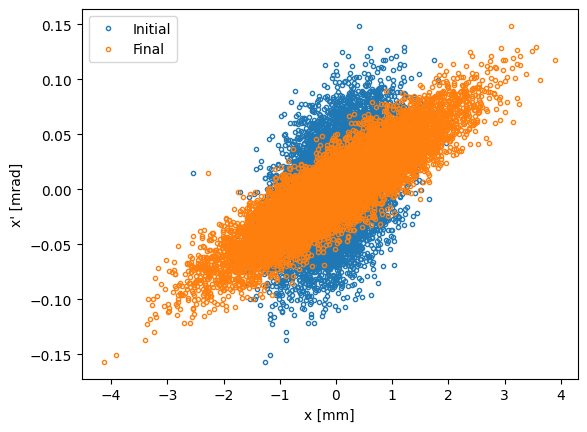

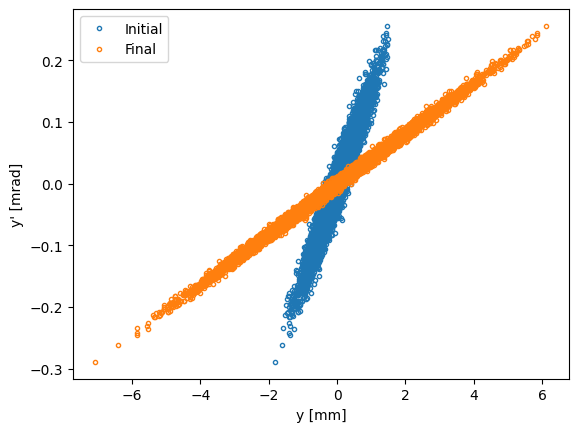

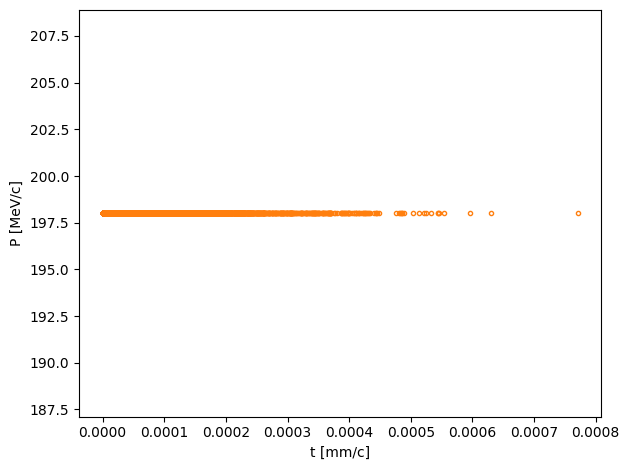

In [23]:
# Phase Space: Initial and Final

M0 = B0.get_phase_space ('%x %xp %y %yp %dt %P')
M1 = B1.get_phase_space ('%x %xp %y %yp %dt %P')

plt.figure()
plt.plot(M0[:,0], M0[:,1], '.', label='Initial', mfc='none')
plt.plot(M1[:,0], M1[:,1], '.', label='Final', mfc='none')
plt.xlabel('x [mm]')
plt.ylabel("x' [mrad]")
plt.legend()

plt.figure()
plt.plot(M0[:,2], M0[:,3], '.', label='Initial', mfc='none')
plt.plot(M1[:,2], M1[:,3], '.', label='Final', mfc='none')
plt.xlabel('y [mm]')
plt.ylabel("y' [mrad]")
plt.legend()

plt.figure()
plt.plot(M0[:,4], M0[:,5], '.', label='Final', mfc='none')
plt.plot(M1[:,4], M1[:,5], '.', label='Final', mfc='none')
plt.xlabel('t [mm/c]')
plt.ylabel('P [MeV/c]')
plt.tight_layout()

# T = L.get_transport_table('%S %sigma_x %sigma_y %sigma_t %sigma_E %mean_E %emitt_x %emitt_y')